# MATH7339 Final Project
## Quick Start Guide for the Team
### By Malick Tobe

**What's this dataset?** Yahoo! Learning to Rank Challenge - basically query-URL pairs with relevance scores (0-4). Good for our bandit project because we can simulate slates and clicks!

**Why this dataset?** 
- Has actual relevance labels we can convert to clicks
- Can match Alibaba's 30-item slate structure
- Different domain (web search vs e-commerce) = shows our approach generalizes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Data Loading Functions
# These handle the weird Yahoo format (space-delimited with qid: prefixes)

def parse_ltrc_line(line):
    """
    Parse a single line from the Yahoo! LTRC dataset.
    Format: <relevance> qid:<query_id> <feature_id>:<value> ... <feature_id>:<value>
    
    Returns:
        dict with 'relevance', 'qid', and feature values
    """
    parts = line.strip().split()
    
    # Extract relevance (first element)
    relevance = int(parts[0])
    
    # Extract query ID
    qid = int(parts[1].split(':')[1])
    
    # Extract features
    features = {}
    for part in parts[2:]:
        if ':' in part:
            feat_id, feat_value = part.split(':')
            features[int(feat_id)] = float(feat_value)
    
    return {
        'relevance': relevance,
        'qid': qid,
        'features': features
    }

def load_ltrc_file(filepath, sample_size=None):
    """
    Load Yahoo! LTRC dataset file into a pandas DataFrame.
    
    Args:
        filepath: Path to the .txt file
        sample_size: If specified, load only first N lines (for faster testing)
    
    Returns:
        DataFrame with columns: relevance, qid, feature_1, feature_2, ..., feature_N
    """
    print(f"Loading {filepath}...")
    
    data = []
    all_features = set()
    
    with open(filepath, 'r') as f:
        for i, line in enumerate(f):
            if sample_size and i >= sample_size:
                break
            
            parsed = parse_ltrc_line(line)
            data.append(parsed)
            all_features.update(parsed['features'].keys())
    
    print(f"Loaded {len(data)} samples with {len(all_features)} unique features")
    
    # Convert to DataFrame
    rows = []
    for sample in data:
        row = {'relevance': sample['relevance'], 'qid': sample['qid']}
        row.update(sample['features'])
        rows.append(row)
    
    df = pd.DataFrame(rows)
    
    # Fill missing features with 0 (they're sparse)
    feature_cols = [col for col in df.columns if col not in ['relevance', 'qid']]
    df[feature_cols] = df[feature_cols].fillna(0)
    
    return df

def load_dataset(set_num=1, sample_size=None):
    """
    Load train, validation, and test sets for a given dataset number.
    
    Args:
        set_num: 1 or 2
        sample_size: If specified, load only first N lines from each file
    
    Returns:
        dict with keys 'train', 'valid', 'test'
    """
    base_path = Path('Learning to Rank Challenge/ltrc_yahoo')
    
    dataset = {
        'train': load_ltrc_file(base_path / f'set{set_num}.train.txt', sample_size),
        'valid': load_ltrc_file(base_path / f'set{set_num}.valid.txt', sample_size),
        'test': load_ltrc_file(base_path / f'set{set_num}.test.txt', sample_size)
    }
    
    return dataset

In [3]:
# Test loading with a small sample
print("Testing data loading with 1000 samples from Set 1...")
sample_data = load_ltrc_file('Learning to Rank Challenge/ltrc_yahoo/set1.train.txt', sample_size=1000)
print(f"\nDataFrame shape: {sample_data.shape}")
print(f"\nFirst few rows:")
print(sample_data.head())

# Notice: Feature IDs are column names (10, 11, 12...). They're already normalized to [0,1]!

Testing data loading with 1000 samples from Set 1...
Loading Learning to Rank Challenge/ltrc_yahoo/set1.train.txt...
Loaded 1000 samples with 514 unique features

DataFrame shape: (1000, 516)

First few rows:
   relevance  qid       10       11       12       17       18       21  \
0          0    1  0.89028  0.75088  0.01343  0.44840  0.90834  0.77818   
1          1    2  0.00000  0.64474  0.50958  0.53111  0.74828  0.76843   
2          0    2  0.00000  0.64474  0.50958  0.33840  0.84784  0.12578   
3          1    2  0.00000  0.64474  0.50958  0.10725  0.81945  0.77818   
4          0    2  0.00000  0.64474  0.50958  0.75808  0.60993  0.47422   

        27       29  ...  615  624  434  324  286  298  367  590  645  333  
0  0.71505  0.77307  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.44586  0.70813  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.18070  0.70813  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.44586  0.70813  ...  0.0  0

In [4]:
# Basic Statistics Functions
# These give us the high-level overview

def get_dataset_statistics(df, set_name=""):
    """Get comprehensive statistics about the dataset."""
    
    stats = {
        'set_name': set_name,
        'total_samples': len(df),
        'num_queries': df['qid'].nunique(),
        'num_features': len([col for col in df.columns if col not in ['relevance', 'qid']]),
        'avg_urls_per_query': len(df) / df['qid'].nunique(),
        'relevance_distribution': df['relevance'].value_counts().sort_index().to_dict(),
        'feature_sparsity': (df.drop(['relevance', 'qid'], axis=1) == 0).sum().sum() / 
                           (df.shape[0] * (df.shape[1] - 2))
    }
    
    return stats

def print_statistics(stats):
    """Print dataset statistics in a readable format."""
    print(f"\n{'='*60}")
    print(f"Dataset: {stats['set_name']}")
    print(f"{'='*60}")
    print(f"Total samples (query-URL pairs): {stats['total_samples']:,}")
    print(f"Unique queries: {stats['num_queries']:,}")
    print(f"Number of features: {stats['num_features']}")
    print(f"Average URLs per query: {stats['avg_urls_per_query']:.2f}")
    print(f"Feature sparsity: {stats['feature_sparsity']:.2%}")
    print(f"\nRelevance Distribution:")
    for rel, count in stats['relevance_distribution'].items():
        print(f"  Level {rel}: {count:,} ({count/stats['total_samples']:.2%})")

In [5]:
# Load and analyze Set 1 (using 10k samples for speed)
# Note: Full Set 1 has ~470k training samples - we're just sampling for quick EDA
print("Loading Set 1 with 10,000 samples per split for quick EDA...")
set1_sample = {
    'train': load_ltrc_file('Learning to Rank Challenge/ltrc_yahoo/set1.train.txt', sample_size=10000),
    'valid': load_ltrc_file('Learning to Rank Challenge/ltrc_yahoo/set1.valid.txt', sample_size=3000),
    'test': load_ltrc_file('Learning to Rank Challenge/ltrc_yahoo/set1.test.txt', sample_size=5000)
}

for split_name, df in set1_sample.items():
    stats = get_dataset_statistics(df, f"Set 1 - {split_name.capitalize()}")
    print_statistics(stats)

# Key observations:
# - About 54-56% of features are zero (sparse)
# - Relevance is fairly balanced (level 1 is most common)
# - Average ~15-19 URLs per query

Loading Set 1 with 10,000 samples per split for quick EDA...
Loading Learning to Rank Challenge/ltrc_yahoo/set1.train.txt...
Loaded 10000 samples with 519 unique features
Loading Learning to Rank Challenge/ltrc_yahoo/set1.valid.txt...
Loaded 3000 samples with 519 unique features
Loading Learning to Rank Challenge/ltrc_yahoo/set1.test.txt...
Loaded 5000 samples with 518 unique features

Dataset: Set 1 - Train
Total samples (query-URL pairs): 10,000
Unique queries: 646
Number of features: 519
Average URLs per query: 15.48
Feature sparsity: 54.76%

Relevance Distribution:
  Level 0: 2,255 (22.55%)
  Level 1: 3,910 (39.10%)
  Level 2: 2,880 (28.80%)
  Level 3: 722 (7.22%)
  Level 4: 233 (2.33%)

Dataset: Set 1 - Valid
Total samples (query-URL pairs): 3,000
Unique queries: 159
Number of features: 519
Average URLs per query: 18.87
Feature sparsity: 56.74%

Relevance Distribution:
  Level 0: 705 (23.50%)
  Level 1: 1,111 (37.03%)
  Level 2: 864 (28.80%)
  Level 3: 245 (8.17%)
  Level 4: 75 (2

In [6]:
# Visualization functions

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

def plot_relevance_distribution(df, title="Relevance Distribution"):
    """Plot distribution of relevance labels."""
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    rel_counts = df['relevance'].value_counts().sort_index()
    bars = ax.bar(rel_counts.index, rel_counts.values, color='steelblue', alpha=0.7)
    
    # Add count labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}',
                ha='center', va='bottom')
    
    ax.set_xlabel('Relevance Level', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xticks([0, 1, 2, 3, 4])
    plt.tight_layout()
    plt.show()

def plot_urls_per_query_distribution(df, title="URLs per Query Distribution"):
    """Plot distribution of how many URLs each query has."""
    urls_per_query = df.groupby('qid').size()
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Histogram
    axes[0].hist(urls_per_query, bins=50, color='coral', alpha=0.7, edgecolor='black')
    axes[0].set_xlabel('Number of URLs per Query', fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    axes[0].set_title('Distribution of URLs per Query', fontsize=12, fontweight='bold')
    axes[0].axvline(urls_per_query.mean(), color='red', linestyle='--', 
                    label=f'Mean: {urls_per_query.mean():.1f}')
    axes[0].axvline(urls_per_query.median(), color='green', linestyle='--',
                    label=f'Median: {urls_per_query.median():.1f}')
    axes[0].legend()
    
    # Box plot
    axes[1].boxplot(urls_per_query, vert=True)
    axes[1].set_ylabel('Number of URLs', fontsize=12)
    axes[1].set_title('URLs per Query Box Plot', fontsize=12, fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nURLs per Query Statistics:")
    print(f"  Mean: {urls_per_query.mean():.2f}")
    print(f"  Median: {urls_per_query.median():.2f}")
    print(f"  Min: {urls_per_query.min()}")
    print(f"  Max: {urls_per_query.max()}")
    print(f"  Std: {urls_per_query.std():.2f}")

def plot_feature_statistics(df, n_features=20):
    """Plot statistics about feature values."""
    feature_cols = [col for col in df.columns if col not in ['relevance', 'qid']]
    
    # Sample features for visualization
    sample_features = np.random.choice(feature_cols, 
                                      size=min(n_features, len(feature_cols)), 
                                      replace=False)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Feature sparsity
    sparsity = (df[feature_cols] == 0).sum() / len(df)
    top_sparse = sparsity.nlargest(20)
    
    axes[0, 0].barh(range(len(top_sparse)), top_sparse.values, color='purple', alpha=0.6)
    axes[0, 0].set_yticks(range(len(top_sparse)))
    axes[0, 0].set_yticklabels([f'Feature {x}' for x in top_sparse.index])
    axes[0, 0].set_xlabel('Sparsity (% zeros)', fontsize=11)
    axes[0, 0].set_title('Top 20 Most Sparse Features', fontsize=12, fontweight='bold')
    axes[0, 0].invert_yaxis()
    
    # 2. Feature value distributions (sample)
    sample_data = df[list(sample_features)[:5]].values.flatten()
    axes[0, 1].hist(sample_data[sample_data > 0], bins=50, color='teal', alpha=0.7)
    axes[0, 1].set_xlabel('Feature Value', fontsize=11)
    axes[0, 1].set_ylabel('Frequency', fontsize=11)
    axes[0, 1].set_title('Distribution of Non-Zero Feature Values', fontsize=12, fontweight='bold')
    
    # 3. Feature means by relevance
    feature_means = []
    for rel in sorted(df['relevance'].unique()):
        means = df[df['relevance'] == rel][feature_cols].mean().mean()
        feature_means.append(means)
    
    axes[1, 0].bar(range(5), feature_means, color='orange', alpha=0.7)
    axes[1, 0].set_xticks(range(5))
    axes[1, 0].set_xticklabels([f'Rel {i}' for i in range(5)])
    axes[1, 0].set_xlabel('Relevance Level', fontsize=11)
    axes[1, 0].set_ylabel('Mean Feature Value', fontsize=11)
    axes[1, 0].set_title('Average Feature Values by Relevance', fontsize=12, fontweight='bold')
    
    # 4. Overall feature sparsity distribution
    axes[1, 1].hist(sparsity, bins=50, color='crimson', alpha=0.7, edgecolor='black')
    axes[1, 1].set_xlabel('Sparsity Rate', fontsize=11)
    axes[1, 1].set_ylabel('Number of Features', fontsize=11)
    axes[1, 1].set_title('Distribution of Feature Sparsity', fontsize=12, fontweight='bold')
    axes[1, 1].axvline(sparsity.mean(), color='blue', linestyle='--',
                      label=f'Mean: {sparsity.mean():.2%}')
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()


VISUALIZING SET 1 TRAINING DATA


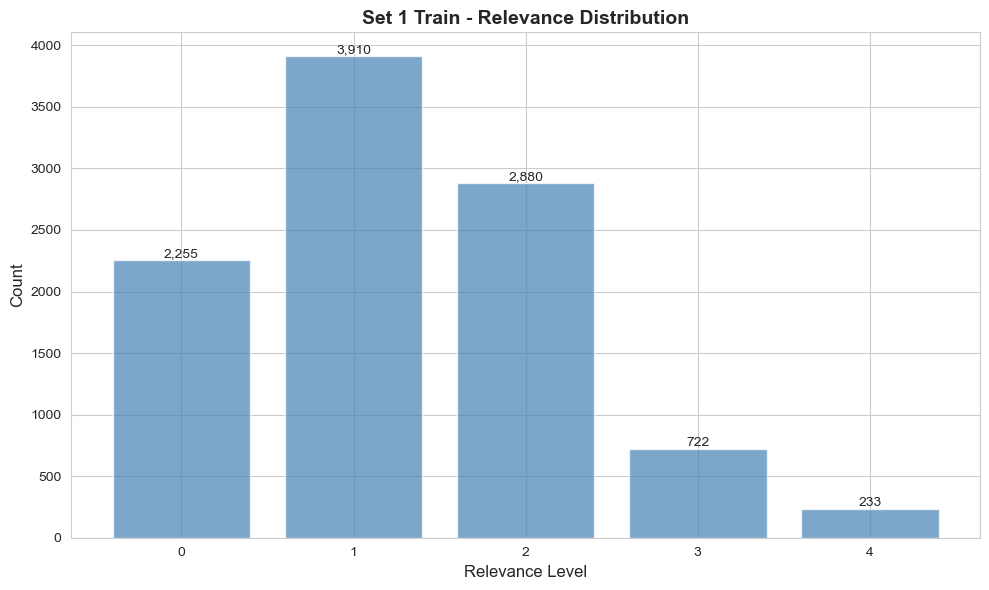

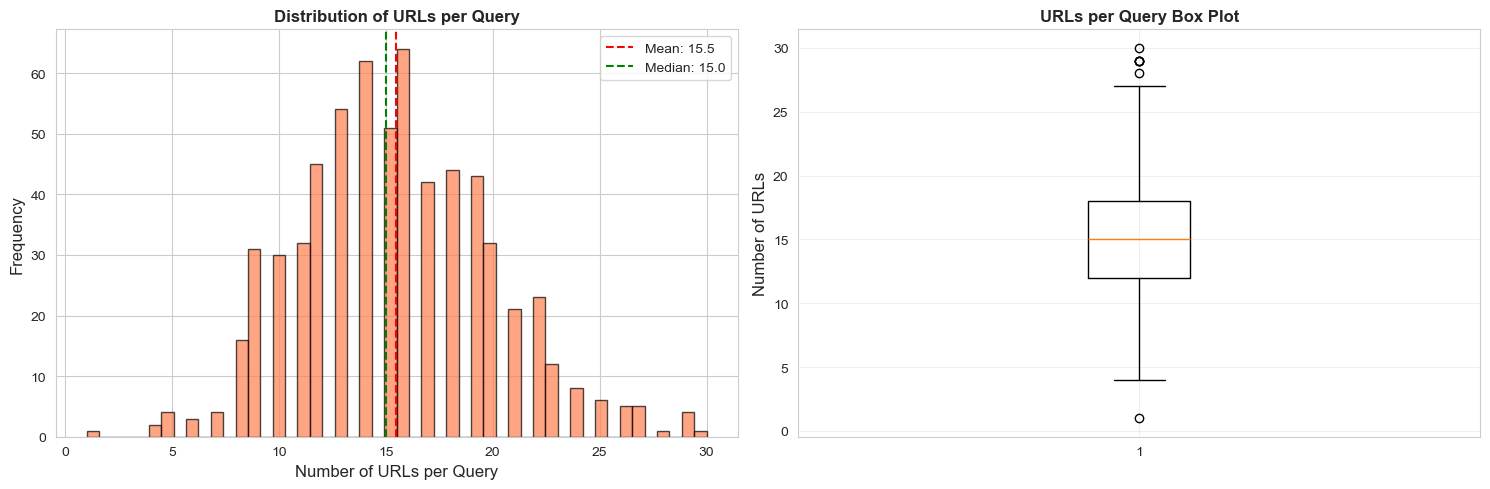


URLs per Query Statistics:
  Mean: 15.48
  Median: 15.00
  Min: 1
  Max: 30
  Std: 4.58


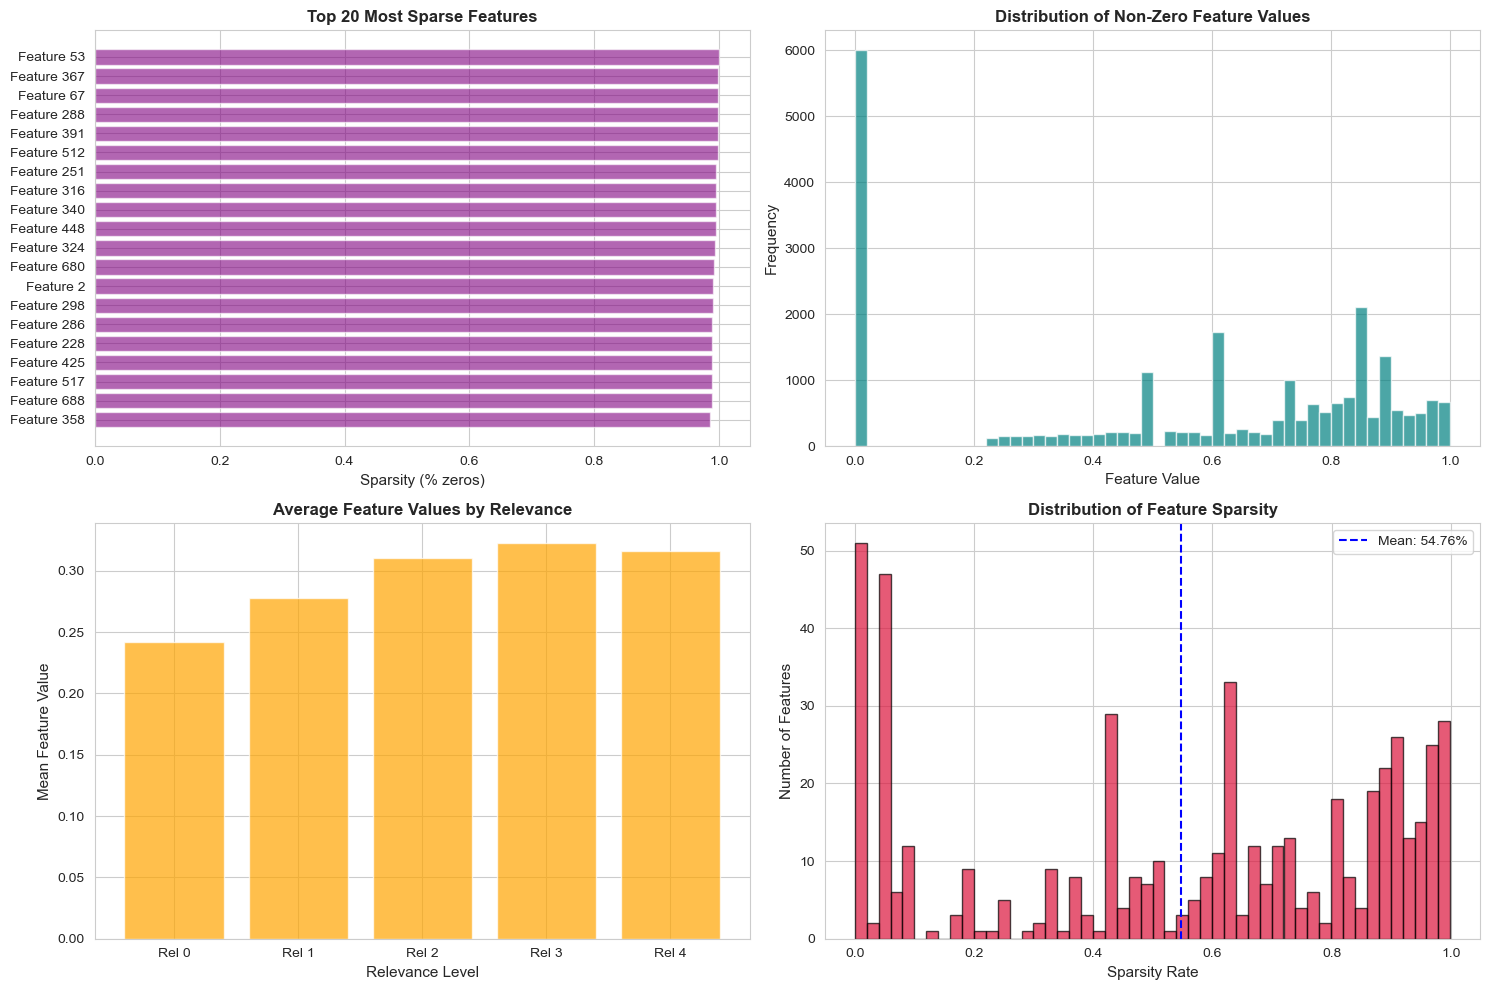

In [7]:
# Run visualizations on training data
print("\n" + "="*60)
print("VISUALIZING SET 1 TRAINING DATA")
print("="*60)

plot_relevance_distribution(set1_sample['train'], "Set 1 Train - Relevance Distribution")
# Notice: Pretty balanced! Level 1 most common, but we have all levels

plot_urls_per_query_distribution(set1_sample['train'], "Set 1 Train - URLs per Query")
# Median is 15 URLs/query. For 30-item slates, we'll need to use full dataset, or adjust slate size. Most queries have 10-20 URLs.

plot_feature_statistics(set1_sample['train'])
# - ~55% sparsity (lots of zeros)
# - Feature values are normalized [0,1]
# - Higher relevance → higher feature values (good sign for models!)

In [8]:
# Query level Analysis

def analyze_query_characteristics(df, n_sample_queries=10):
    """
    Analyze individual queries - crucial for understanding slate generation.
    """
    print("\n" + "="*60)
    print("QUERY-LEVEL ANALYSIS")
    print("="*60)
    
    # Group by query
    query_groups = df.groupby('qid')
    
    # Sample some queries to examine
    sample_qids = np.random.choice(df['qid'].unique(), size=n_sample_queries, replace=False)
    
    print(f"\nAnalyzing {n_sample_queries} random queries...\n")
    
    for qid in sample_qids:
        query_data = df[df['qid'] == qid]
        rel_dist = query_data['relevance'].value_counts().sort_index()
        
        print(f"Query ID: {qid}")
        print(f"  Total URLs: {len(query_data)}")
        print(f"  Relevance distribution: {dict(rel_dist)}")
        print(f"  Has highly relevant (rel=4): {(query_data['relevance'] == 4).any()}")
        print(f"  Has relevant (rel>=2): {(query_data['relevance'] >= 2).sum()}")
        print()
    
    # Overall query statistics
    print("\n" + "-"*60)
    print("OVERALL QUERY STATISTICS")
    print("-"*60)
    
    queries_with_relevant = sum((query_groups['relevance'].max() >= 2).values)
    queries_with_highly_relevant = sum((query_groups['relevance'].max() == 4).values)
    
    print(f"Total queries: {df['qid'].nunique()}")
    print(f"Queries with at least one relevant URL (rel>=2): {queries_with_relevant}")
    print(f"Queries with at least one highly relevant URL (rel=4): {queries_with_highly_relevant}")
    
    # Distribution of max relevance per query
    max_rel_per_query = query_groups['relevance'].max()
    print(f"\nDistribution of maximum relevance per query:")
    for rel in sorted(max_rel_per_query.unique()):
        count = (max_rel_per_query == rel).sum()
        print(f"  Max rel {rel}: {count} queries ({count/len(max_rel_per_query):.2%})")
    
    return query_groups

query_groups = analyze_query_characteristics(set1_sample['train'], n_sample_queries=10)

# - Most queries have at least SOME relevant results
# - About 25% of queries have highly relevant results (rel=4)
# - This is good for our click simulation!


QUERY-LEVEL ANALYSIS

Analyzing 10 random queries...

Query ID: 51
  Total URLs: 16
  Relevance distribution: {0: 5, 1: 11}
  Has highly relevant (rel=4): False
  Has relevant (rel>=2): 0

Query ID: 163
  Total URLs: 16
  Relevance distribution: {1: 7, 2: 9}
  Has highly relevant (rel=4): False
  Has relevant (rel>=2): 9

Query ID: 375
  Total URLs: 21
  Relevance distribution: {0: 2, 1: 4, 2: 5, 3: 9, 4: 1}
  Has highly relevant (rel=4): True
  Has relevant (rel>=2): 15

Query ID: 395
  Total URLs: 12
  Relevance distribution: {1: 5, 2: 5, 3: 1, 4: 1}
  Has highly relevant (rel=4): True
  Has relevant (rel>=2): 7

Query ID: 123
  Total URLs: 10
  Relevance distribution: {0: 1, 1: 3, 2: 5, 3: 1}
  Has highly relevant (rel=4): False
  Has relevant (rel>=2): 6

Query ID: 217
  Total URLs: 21
  Relevance distribution: {0: 4, 1: 9, 2: 6, 3: 2}
  Has highly relevant (rel=4): False
  Has relevant (rel>=2): 8

Query ID: 424
  Total URLs: 19
  Relevance distribution: {0: 7, 1: 7, 2: 3, 3: 2}


In [9]:
query_groups.head()

,relevance,qid,10,11,12,17,18,21,27,29,...,298,367,590,645,333,53,67,288,391,512
0,0,1,0.89028,0.75088,0.01343,0.448400,0.90834,0.778180,0.71505,0.77307,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2,0.00000,0.64474,0.50958,0.531110,0.74828,0.768430,0.44586,0.70813,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,2,0.00000,0.64474,0.50958,0.338400,0.84784,0.125780,0.18070,0.70813,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,2,0.00000,0.64474,0.50958,0.107250,0.81945,0.778180,0.44586,0.70813,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,2,0.00000,0.64474,0.50958,0.758080,0.60993,0.474220,0.71505,0.70813,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9992,2,646,0.00000,0.77686,0.50958,0.623060,0.96360,0.302670,0.49748,0.93923,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9993,1,646,0.00000,0.49900,0.50958,0.094804,0.66821,0.000000,0.28768,0.93923,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9994,1,646,0.00000,0.49900,0.50958,0.587800,0.93215,0.302670,0.71200,0.93923,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9995,1,646,0.00000,0.77686,0.50958,0.770570,0.94841,0.397130,0.24379,0.93923,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
def simulate_slate_for_query(df, qid, slate_size=30):
    """
    Extract a slate of URLs for a given query.
    This simulates what your ranking models will produce.
    
    Args:
        df: DataFrame with query-URL pairs
        qid: Query ID
        slate_size: Number of URLs to include in slate (default 30, matching Alibaba)
    
    Returns:
        DataFrame with the slate and associated features
    """
    query_data = df[df['qid'] == qid].copy()
    
    # If query has fewer URLs than slate_size, use all
    if len(query_data) < slate_size:
        print(f"Warning: Query {qid} has only {len(query_data)} URLs (< {slate_size})")
        return query_data
    
    # Otherwise, take top slate_size
    return query_data.head(slate_size)

def click_probability_from_relevance(relevance):
    """
    Convert relevance score to click probability.
    This is crucial for simulating user clicks in your bandit framework.
    
    You can tune these probabilities based on literature or empirical data.
    """
    click_probs = {
        0: 0.05,   # Very low relevance - rare accidental clicks
        1: 0.15,   # Low relevance
        2: 0.35,   # Medium relevance
        3: 0.60,   # High relevance
        4: 0.85    # Very high relevance
    }
    return click_probs.get(relevance, 0.0)

def simulate_clicks_for_slate(slate_df):
    """
    Simulate user clicks on a slate based on relevance scores.
    
    Returns:
        slate_df with additional 'click' column (0 or 1)
    """
    slate_df = slate_df.copy()
    slate_df['click_prob'] = slate_df['relevance'].apply(click_probability_from_relevance)
    slate_df['click'] = (np.random.random(len(slate_df)) < slate_df['click_prob']).astype(int)
    
    return slate_df

# Test slate generation
print("\n" + "="*60)
print("SLATE GENERATION SIMULATION TEST")
print("="*60)

# Pick a random query
test_qid = set1_sample['train']['qid'].iloc[0]
slate = simulate_slate_for_query(set1_sample['train'], test_qid, slate_size=30)

print(f"\nGenerated slate for Query ID: {test_qid}")
print(f"Slate size: {len(slate)}")
print(f"\nRelevance distribution in slate:")
print(slate['relevance'].value_counts().sort_index())

# Simulate clicks
slate_with_clicks = simulate_clicks_for_slate(slate)
print(f"\nSimulated clicks: {slate_with_clicks['click'].sum()} out of {len(slate)}")
print(f"Click-through rate: {slate_with_clicks['click'].mean():.2%}")

print("\nSample of slate with simulated clicks:")
print(slate_with_clicks[['relevance', 'click_prob', 'click']].head(10))


SLATE GENERATION SIMULATION TEST

Generated slate for Query ID: 1
Slate size: 1

Relevance distribution in slate:
relevance
0    1
Name: count, dtype: int64

Simulated clicks: 1 out of 1
Click-through rate: 100.00%

Sample of slate with simulated clicks:
   relevance  click_prob  click
0          0        0.05      1


In [11]:
# Final summary with all the key numbers

def generate_eda_summary(dataset_dict, set_name="Set 1"):
    """Generate a comprehensive summary for your project report."""
    
    print("\n" + "="*70)
    print(f"EDA SUMMARY - {set_name}")
    print("="*70)
    
    for split, df in dataset_dict.items():
        print(f"\n{split.upper()} SET:")
        print(f"  Samples: {len(df):,}")
        print(f"  Queries: {df['qid'].nunique():,}")
        print(f"  Features: {len([c for c in df.columns if c not in ['relevance', 'qid']])}")
        
        urls_per_query = df.groupby('qid').size()
        print(f"  URLs per query (mean±std): {urls_per_query.mean():.1f}±{urls_per_query.std():.1f}")
        print(f"  URLs per query (median): {urls_per_query.median():.0f}")
        
        print(f"  Relevance distribution:")
        for rel in sorted(df['relevance'].unique()):
            count = (df['relevance'] == rel).sum()
            pct = count / len(df) * 100
            print(f"    Level {rel}: {count:>8,} ({pct:>5.2f}%)")
    
    print("\n" + "="*70)
    print("KEY INSIGHTS FOR YOUR PROJECT:")
    print("="*70)
    
    train_df = dataset_dict['train']
    
    # Queries suitable for slate generation
    urls_per_query = train_df.groupby('qid').size()
    suitable_queries = (urls_per_query >= 30).sum()
    
    print(f"\n1. SLATE GENERATION:")
    print(f"   - Queries with ≥30 URLs: {suitable_queries:,} ({suitable_queries/len(urls_per_query):.1%})")
    print(f"   - Median URLs per query: {urls_per_query.median():.0f}")
    print(f"   - Can generate {suitable_queries:,} full slates of 30 items")
    
    print(f"\n2. CLICK SIMULATION:")
    high_rel = (train_df['relevance'] >= 3).sum()
    print(f"   - URLs with high relevance (≥3): {high_rel:,} ({high_rel/len(train_df):.1%})")
    print(f"   - Expected CTR with current click model: {train_df['relevance'].apply(click_probability_from_relevance).mean():.2%}")
    
    print(f"\n3. MODEL TRAINING:")
    print(f"   - Training samples: {len(dataset_dict['train']):,}")
    print(f"   - Feature dimensionality: {len([c for c in train_df.columns if c not in ['relevance', 'qid']])}")
    print(f"   - Can train diverse models (linear, tree-based, neural) easily")
    
    print(f"\n4. COMPARISON WITH ALIBABA:")
    print(f"   - Alibaba: E-commerce, 30-item slates, implicit clicks")
    print(f"   - Yahoo: Web search, 30-item slates (matched), simulated clicks from relevance")
    print(f"   - Shows generalization across domains!")

In [12]:
generate_eda_summary(set1_sample, "Set 1 (Sample)")


EDA SUMMARY - Set 1 (Sample)

TRAIN SET:
  Samples: 10,000
  Queries: 646
  Features: 519
  URLs per query (mean±std): 15.5±4.6
  URLs per query (median): 15
  Relevance distribution:
    Level 0:    2,255 (22.55%)
    Level 1:    3,910 (39.10%)
    Level 2:    2,880 (28.80%)
    Level 3:      722 ( 7.22%)
    Level 4:      233 ( 2.33%)

VALID SET:
  Samples: 3,000
  Queries: 159
  Features: 519
  URLs per query (mean±std): 18.9±11.5
  URLs per query (median): 16
  Relevance distribution:
    Level 0:      705 (23.50%)
    Level 1:    1,111 (37.03%)
    Level 2:      864 (28.80%)
    Level 3:      245 ( 8.17%)
    Level 4:       75 ( 2.50%)

TEST SET:
  Samples: 5,000
  Queries: 314
  Features: 518
  URLs per query (mean±std): 15.9±4.5
  URLs per query (median): 16
  Relevance distribution:
    Level 0:    1,197 (23.94%)
    Level 1:    1,812 (36.24%)
    Level 2:    1,504 (30.08%)
    Level 3:      356 ( 7.12%)
    Level 4:      131 ( 2.62%)

KEY INSIGHTS FOR YOUR PROJECT:

1. SLATE 